<a href="https://colab.research.google.com/github/OluochOdhiambo/Tuberculosis-X-Ray-Classification/blob/main/Tuberculosis_X_Ray_Classification_(Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Runmila AI Institute & minoHealth AI Labs Tuberculosis Classification via X-Rays.

This competition was hosted on Zindi and can be accessed here https://zindi.africa/competitions/runmila-ai-institute-minohealth-ai-labs-tuberculosis-classification-via-x-rays-challenge. The objective of the challenge is to build a model that can classify Tuberculosis and Normal X-Ray results. For this notebook, I implemented transfer learning using the VGG16 pretrained model.

### 1. Importing libraries

In [1]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# import relevant libraries
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
#seed for reproducibility
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### 2. Load data

In [4]:
# extract train files
import zipfile 
train_file = "/content/drive/My Drive/train.zip"
with zipfile.ZipFile(train_file, 'r') as z:
    z.extractall()

In [5]:
# extract test files
import zipfile 
test_file = "/content/drive/My Drive/test.zip"
with zipfile.ZipFile(test_file, 'r') as z:
    z.extractall()

In [3]:
# reading data
train_data = pd.read_csv('Train (1).csv')
test_data = pd.read_csv('Test (1).csv')
train_path = '/content/train/'
test_path = '/content/test/'

In [4]:
# creating train and test dataframe using flow_from_dataframe

# train
train_names = train_data.ID.values
train_labels = np.asarray(train_data['LABEL'].values)
train_dict = {'filepath': train_path + train_names + '.png', 'LABEL': train_labels}
train = pd.DataFrame(data=train_dict)
train['ID'] = train_data['ID']
train['LABEL'] = train.LABEL.apply(lambda x: 'Positive' if x == 1 else 'Normal')

# test
test_names = test_data.ID.values
test_dict = {'filepath': test_path + test_names + '.png'}
test = pd.DataFrame(data=test_dict)
test['ID'] = test_data['ID']

In [5]:
# preview train file
train.head()

,filepath,LABEL,ID
0,/content/train/VTYNBFTO.png,Positive,VTYNBFTO
1,/content/train/GVVXXDOZ.png,Normal,GVVXXDOZ
2,/content/train/PMRSQLXN.png,Normal,PMRSQLXN
3,/content/train/JXISWDUU.png,Positive,JXISWDUU
4,/content/train/JVWMAACC.png,Positive,JVWMAACC


In [6]:
# preview test file 
test.head()

,filepath,ID
0,/content/test/GTWSHFYQ.png,GTWSHFYQ
1,/content/test/QTFSSMGD.png,QTFSSMGD
2,/content/test/TBLBHSYT.png,TBLBHSYT
3,/content/test/ZKETEOFG.png,ZKETEOFG
4,/content/test/GKTPBGZP.png,GKTPBGZP


In [7]:
# check dimensions
train.shape, test.shape

((718, 3), (82, 2))

### 3. EDA and Preprocessing

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


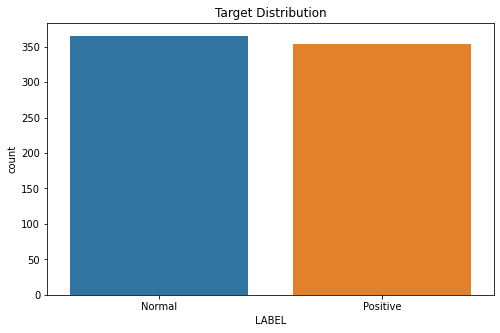

In [8]:
# visualizing target distribution 
f, ax = plt.subplots(1,1, figsize=(8,5))
sns.countplot(train['LABEL'],order = train['LABEL'].value_counts().index)
plt.title("Target Distribution")
plt.show()

We observe that the data set has a nearly equal number of images form both classes.

In [9]:
# check percentage distribution
train.LABEL.value_counts()/len(train)

Normal      0.508357
Positive    0.491643
Name: LABEL, dtype: float64

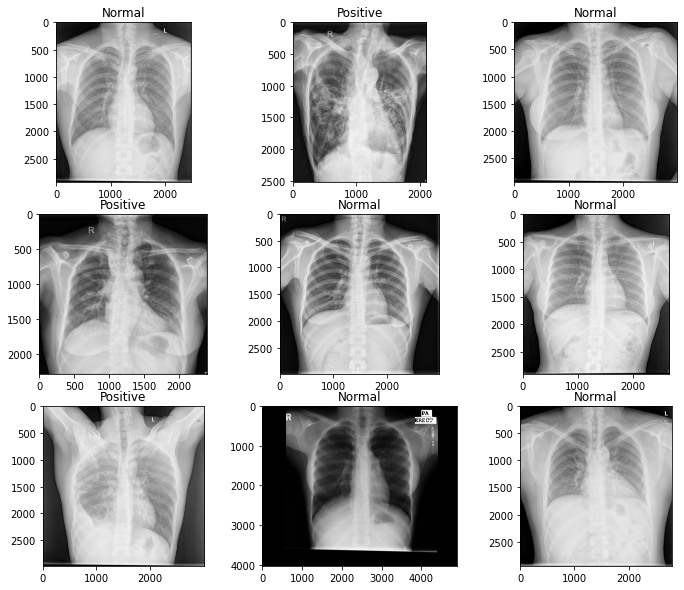

In [10]:
#visualizing random images
nrows = 3
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'LABEL'])
plt.show()

In [11]:
train.tail()

,filepath,LABEL,ID
713,/content/train/EWGJDECH.png,Positive,EWGJDECH
714,/content/train/CJEVKQUT.png,Positive,CJEVKQUT
715,/content/train/YDXXBDGI.png,Positive,YDXXBDGI
716,/content/train/QLUOORWZ.png,Normal,QLUOORWZ
717,/content/train/HFAGCLGV.png,Positive,HFAGCLGV


In [12]:
# lets split our training data into train and validation set  
df_train = train[:500:]
df_val = train[500:]
print(df_train.LABEL.value_counts())
print(df_val.LABEL.value_counts())

Positive    251
Normal      249
Name: LABEL, dtype: int64
Normal      116
Positive    102
Name: LABEL, dtype: int64


In [13]:
# create data generators
batch_size = 64  
image_size = (224, 224)
learning_rate = 0.0001

train_steps = np.ceil(len(df_train) / batch_size)
val_steps = np.ceil(len(df_val) / batch_size )

classes = train.LABEL.unique().tolist()

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip=True,
                             vertical_flip=True,shear_range=10,zoom_range=0.2,width_shift_range=0.1,
                             height_shift_range=0.1,channel_shift_range=10.)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_datagen.flow_from_dataframe(df_train,x_col='filepath', y_col='LABEL',
                                        target_size=image_size,classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical', shuffle=True, seed=SEED)

val_ds = val_datagen.flow_from_dataframe(df_val,x_col='filepath', y_col='LABEL',
                                        target_size=image_size,classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical', shuffle=False, seed=SEED)

test_ds = val_datagen.flow_from_dataframe(test, x_col='filepath',target_size=image_size, class_mode=None,
                                          shuffle=False,batch_size=batch_size)#set shuffle=False for test dataset not be shuffled

Found 500 validated image filenames belonging to 2 classes.
Found 218 validated image filenames belonging to 2 classes.
Found 82 validated image filenames.


### 4. Modelling

In [14]:
# we will use transfer learning from VGG16 model

def BuildModel (pretrained=VGG16):

    base_model = pretrained(include_top=False, weights='imagenet', input_shape=(224, 224,3)) #include_top=False to remove the last layer 

    for layer in base_model.layers:
        layer.trainable = False   #freeze trainable layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dense(3072, activation='relu', )(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    output = Dense(2, activation='softmax')(x) 
    
    model = Model(base_model.input, output)
    
    return model

In [15]:
model6 = BuildModel()

In [16]:
#compile model
optimizer = keras.optimizers.Adam(lr=learning_rate)
model6.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])

In [17]:
#callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
chkpt_path = os.path.join("/content/drive/My Drive/models/", f"tb_model.h5", )
checkpoint = ModelCheckpoint(chkpt_path, monitor='val_loss',mode='auto', verbose=1, save_best_only=True,)

In [20]:
#fit model
history = model6.fit(train_ds, epochs=15,steps_per_epoch=train_steps, callbacks=[earlystop, checkpoint],
                    verbose=1, shuffle=False,validation_data=(val_ds), validation_steps= val_steps)

Epoch 1/15
8/8 [==============================] - ETA: 0s - loss: 0.4720 - auc: 0.8878
Epoch 00001: val_loss improved from 0.45511 to 0.45163, saving model to /content/drive/My Drive/models/tb_model.h5
8/8 [==============================] - 82s 10s/step - loss: 0.4720 - auc: 0.8878 - val_loss: 0.4516 - val_auc: 0.8683
Epoch 2/15
8/8 [==============================] - ETA: 0s - loss: 0.4512 - auc: 0.8941
Epoch 00002: val_loss did not improve from 0.45163
8/8 [==============================] - 77s 10s/step - loss: 0.4512 - auc: 0.8941 - val_loss: 0.4524 - val_auc: 0.8688
Epoch 3/15
8/8 [==============================] - ETA: 0s - loss: 0.4180 - auc: 0.9037
Epoch 00003: val_loss improved from 0.45163 to 0.44899, saving model to /content/drive/My Drive/models/tb_model.h5
8/8 [==============================] - 78s 10s/step - loss: 0.4180 - auc: 0.9037 - val_loss: 0.4490 - val_auc: 0.8726
Epoch 4/15
8/8 [==============================] - ETA: 0s - loss: 0.4587 - auc: 0.8867
Epoch 00004: val_

In [21]:
#AUC
y_pred = model6.predict(val_ds, verbose=1)[:, 1] 
fpr, tpr, thresholds = roc_curve(val_ds.classes, y_pred)
auc = auc(fpr, tpr)
auc

4/4 [==============================] - 18s 4s/step


TypeError: ignored

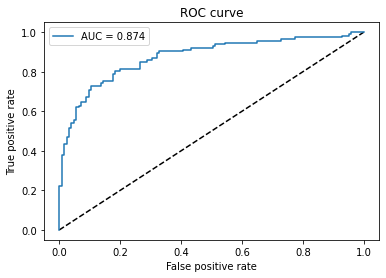

In [20]:
## plotting AUC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### 5. Submission

In [22]:
#make predictions on test data
predictions = model6.predict(test_ds)[:, 1]

In [23]:
submission = pd.DataFrame()
submission['ID'] = test['ID']
submission['LABEL'] = predictions

In [24]:
submission

,ID,LABEL
0,GTWSHFYQ,0.223279
1,QTFSSMGD,0.047744
2,TBLBHSYT,0.675764
3,ZKETEOFG,0.714699
4,GKTPBGZP,0.687808
...,...,...
77,UHRZNUCQ,0.667468
78,RQZCAYRX,0.533248
79,KGOETYSK,0.101086
80,ZPPGWFUO,0.924524


In [25]:
submission.to_csv('/content/drive/My Drive/submissions/submission.csv', index=False)

With transfer learning, my model ranked 8th on the leaderboard.